In [24]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import StratifiedShuffleSplit
import xgboost as xgb
import numpy as np 
import os
import datetime
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

# Model training

In [25]:
# Input model dataset
df1_data=pd.read_excel("Data sources/Model dataset/model_dataset.xlsx",sheet_name = "Sheet1")
df1_data

,Sample,Label,Depth,CO2,lg(CO2),SiO2,TiO2,Al2O3,FeOT,MnO,...,K2O,P2O5,Rb,Nb,Ba,La,Ce,Sm,Th,U
0,PS59-199-003,1,4487.0,211.473454,2.325256,48.070000,1.220000,17.620000,11.040000,0.188738,...,0.049000,0.077000,0.616027,1.155803,8.651638,1.942953,6.870989,2.339513,0.080894,0.027202
1,HLY0102-027-029,1,4033.0,197.290533,2.295106,48.910000,1.060000,16.900000,8.580000,0.155309,...,0.069000,0.088000,0.742277,0.634892,7.023172,1.440000,5.258259,2.505616,0.045769,0.020117
2,HLY0102-055-019,1,4174.0,171.229678,2.233579,48.131048,1.054847,17.684743,9.556447,0.177335,...,0.075264,0.081637,0.767817,0.951519,6.094414,2.118470,7.543773,2.316028,0.094299,0.043274
3,MW8801 17-26,1,3410.0,159.806817,2.203595,50.557700,1.299970,15.730000,8.510000,0.160000,...,0.030232,0.120927,0.165543,0.664344,1.746830,1.950000,9.732383,2.900453,0.040197,0.017114
4,RC2806 1D-1g,1,3740.0,171.284644,2.233718,50.780000,1.140000,15.270000,9.320000,0.160000,...,0.035000,0.070000,0.132223,0.619180,1.725321,1.473282,5.254593,2.572303,0.034094,0.013054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,Midfell-34,9,NaN,418.668795,2.621871,49.579000,0.844000,16.318000,6.413000,0.164000,...,0.034000,0.038000,NaN,0.324050,4.084100,0.498092,2.227789,1.442077,NaN,NaN
451,Midfell-35,9,NaN,670.758292,2.826566,48.731000,0.868000,16.334000,7.707000,0.199000,...,0.028000,0.031000,NaN,0.742208,5.904687,1.086671,2.742565,1.296917,NaN,NaN
452,Midfell-36,9,NaN,268.604802,2.429114,49.718000,0.702000,15.929000,6.857000,0.184000,...,0.042000,0.050000,NaN,0.313202,1.400458,0.527800,1.725042,1.137047,NaN,NaN
453,Midfell-37,9,NaN,1079.284469,3.033136,49.021000,0.774000,15.930000,7.433000,0.131000,...,0.045000,0.022000,NaN,0.628605,6.336694,1.177826,2.998215,1.185317,NaN,NaN


In [35]:
# Select eigenvalues and 'tag' value
X = df1_data.loc[:,['Depth','SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MnO','K2O', 'MgO','Na2O','P2O5','CaO', 
                    'Ba','Nb','Rb','La','Ce','Th','U','Sm']]
y = df1_data["lg(CO2)"].copy()

X

,Depth,SiO2,TiO2,Al2O3,FeOT,MnO,K2O,MgO,Na2O,P2O5,CaO,Ba,Nb,Rb,La,Ce,Th,U,Sm
0,4487.0,48.070000,1.220000,17.620000,11.040000,0.188738,0.049000,8.50000,2.900000,0.077000,11.037396,8.651638,1.155803,0.616027,1.942953,6.870989,0.080894,0.027202,2.339513
1,4033.0,48.910000,1.060000,16.900000,8.580000,0.155309,0.069000,9.06000,2.640000,0.088000,11.960000,7.023172,0.634892,0.742277,1.440000,5.258259,0.045769,0.020117,2.505616
2,4174.0,48.131048,1.054847,17.684743,9.556447,0.177335,0.075264,8.88509,2.943909,0.081637,10.848062,6.094414,0.951519,0.767817,2.118470,7.543773,0.094299,0.043274,2.316028
3,3410.0,50.557700,1.299970,15.730000,8.510000,0.160000,0.030232,8.68000,2.851870,0.120927,11.820700,1.746830,0.664344,0.165543,1.950000,9.732383,0.040197,0.017114,2.900453
4,3740.0,50.780000,1.140000,15.270000,9.320000,0.160000,0.035000,8.69000,2.360000,0.070000,12.530000,1.725321,0.619180,0.132223,1.473282,5.254593,0.034094,0.013054,2.572303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,NaN,49.579000,0.844000,16.318000,6.413000,0.164000,0.034000,8.68500,1.575000,0.038000,16.212000,4.084100,0.324050,NaN,0.498092,2.227789,NaN,NaN,1.442077
451,NaN,48.731000,0.868000,16.334000,7.707000,0.199000,0.028000,9.21200,1.529000,0.031000,15.234000,5.904687,0.742208,NaN,1.086671,2.742565,NaN,NaN,1.296917
452,NaN,49.718000,0.702000,15.929000,6.857000,0.184000,0.042000,9.68300,1.512000,0.050000,15.166000,1.400458,0.313202,NaN,0.527800,1.725042,NaN,NaN,1.137047
453,NaN,49.021000,0.774000,15.930000,7.433000,0.131000,0.045000,9.69200,1.465000,0.022000,15.385000,6.336694,0.628605,NaN,1.177826,2.998215,NaN,NaN,1.185317


In [36]:
# Stratified random sampling
split_xgb = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=12)
# divide augmented X and y into training and testing data
for train_index, test_index in split_xgb.split(df1_data, df1_data["Label"]):
    X_train = X.loc[train_index]
    X_test = X.loc[test_index] 
    y_train = y.loc[train_index]
    y_test = y.loc[test_index]

TRAIN RMSE =  0.149
TEST RMSE =  0.119
TRAIN R2 = 0.984
TEST R2 = 0.984


<function matplotlib.pyplot.show(close=None, block=None)>

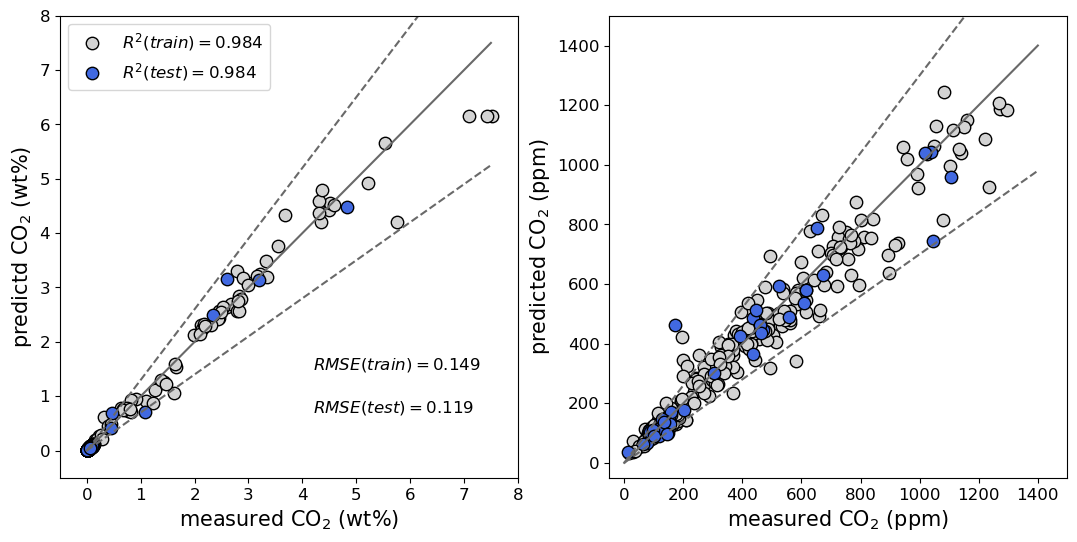

In [43]:
# Set the hyperparameters of the XGBoost Regressor model and train the model
xgb = XGBRegressor()
model_xgb = XGBRegressor(base_score=0, booster ='gbtree',colsample_bylevel = 1, colsample_bynode = 1,max_delta_step = 0,
                         reg_alpha = 0.1,reg_lambda = 0.1, tree_method = 'exact',validate_parameters = 1,num_parallel_tree = 1,
                         colsample_bytree = 0.8,eta = 0.04, subsample = 0.8,max_depth = 3,min_child_weight = 10,gamma = 0.01,
                         n_estimators = 270,random_state = 6)
model_xgb.fit(X_train,y_train)

# Get the scores of both the training and testing data
y_test_predict = model_xgb.predict(X_test)
y_train_predict = model_xgb.predict(X_train)

y_test_predict_log = 10**(y_test_predict)/10000
y_train_predict_log = 10**(y_train_predict)/10000
y_test_log = 10**(y_test)/10000
y_train_log = 10**(y_train)/10000

train_rmse_log = np.around(np.sqrt(mean_squared_error(y_train_log, y_train_predict_log)), decimals=3)
test_rmse_log = np.around(np.sqrt(mean_squared_error(y_test_log, y_test_predict_log)), decimals=3)
train_r2_log = np.around(r2_score(y_train_log, y_train_predict_log), decimals=3)
test_r2_log = np.around(r2_score(y_test_log, y_test_predict_log), decimals=3)


print("TRAIN RMSE = ",train_rmse_log)
print("TEST RMSE = ",test_rmse_log)
print("TRAIN R2 =",train_r2_log)
print("TEST R2 =",test_r2_log)


# Plot binary diagram
plt.figure(figsize = (13,6))

ax1 = plt.subplot(121)
p1 = max(max(y_test_predict_log),max(y_test_log))
p2 = min(min(y_test_predict_log),min(y_test_log))
plt.plot([0,7.5],[0,7.5],color = 'dimgrey', linestyle='-')
plt.plot([0,7.5],[0,5.25],color = 'dimgrey', linestyle='--')
plt.plot([0,7.5],[0,9.75],color = 'dimgrey', linestyle='--')
plt.xlabel('measured CO$_2$ (wt%)', fontsize =15)
plt.ylabel('predictd CO$_2$ (wt%)', fontsize =15)
plt.scatter(y_train_log,y_train_predict_log,marker='o',label=r'$R^2(train)=${}'.format(train_r2_log),  s=80, color='lightgrey',  edgecolors = 'black')
plt.scatter(y_test_log,y_test_predict_log,marker='o',label=r'$R^2(test)=${}'.format(test_r2_log),  s=80,  color='royalblue',  edgecolors = 'black')
plt.xlim((-0.5,8))
plt.ylim((-0.5,8))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', fontsize=12)

text_position = [6, 3]
plt.text(text_position[0]-1.8, text_position[1]-1.5,
             "$RMSE(train)=${}".format(train_rmse_log),
             fontdict={'size': 12, 'color': '#000000'})
plt.text(text_position[0]-1.8, text_position[1]-2.3,
             "$RMSE(test)=${}".format(test_rmse_log),
             fontdict={'size': 12, 'color': '#000000'})


y_test_predict_log = 10**(y_test_predict)
y_train_predict_log = 10**(y_train_predict)
y_test_log = 10**(y_test)
y_train_log = 10**(y_train)
ax2 = plt.subplot(122)
plt.plot([0,1400],[0,1400],color = 'dimgrey', linestyle='-')
plt.plot([0,1400],[0,1820],color = 'dimgrey', linestyle='--')
plt.plot([0,1400],[0,980],color = 'dimgrey', linestyle='--')
plt.xlabel('measured CO$_2$ (ppm)', fontsize =15)
plt.ylabel('predicted CO$_2$ (ppm)', fontsize =15)
plt.scatter(y_train_log,y_train_predict_log, marker='o',  s=80 ,  color='lightgrey', edgecolors = 'black')
plt.scatter(y_test_log,y_test_predict_log, marker='o',  s=80, color='royalblue',  edgecolors = 'black')
plt.ylim((-50,1500))
plt.xlim((-50,1500))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the figure
#plt.savefig("model_xgb.svg", format='svg', dpi=600)
plt.show

In [44]:
# Output save the predicted testing data results
list_test = []
list_test.append(y_test_predict)
df_test = pd.DataFrame(y_test_predict)
X_test['CO2-ML'] = y_test_predict_log
X_test['CO2'] = y_test_log
df_test= X_test
#df_test.to_excel("result_test.xlsx")

# Prediction via ML model

In [19]:
# Input the implication dataset
df_prediction=pd.read_excel("Data sources/Implication dataset/implication_dataset.xlsx",sheet_name = "Sheet1")

X_prediction = df_prediction.loc[:,['Depth','SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MnO','K2O', 'MgO','Na2O','P2O5','CaO', 
                    'Ba','Nb','Rb','La','Ce','Th','U','Sm']]
y_prediction_log = model_xgb.predict(X_prediction)
y_prediction = 10**(y_prediction_log)
df_prediction['CO2-ML'] = y_prediction
df= df_prediction
df
# Output and save the predicted results
#df.to_excel("prediction_global.xlsx")

,Sample,Depth,SiO2,TiO2,Al2O3,FeOT,MnO,MgO,CaO,Na2O,...,P2O5,Rb,Nb,Ba,La,Ce,Sm,Th,U,CO2-ML
0,43435,4000.0,49.690000,1.404700,17.020000,8.2000,0.149200,8.3000,11.1200,2.866700,...,0.1411,2.040834,3.574412,20.224233,4.417769,12.466913,2.973969,NaN,0.091040,2423.941895
1,44574,4116.0,48.410000,1.202500,16.910000,7.9700,0.125500,8.3600,10.9600,3.430000,...,0.1281,2.082258,3.533086,19.899676,4.302308,12.240526,3.000218,NaN,0.078197,2470.509277
2,13-9,4090.0,49.400000,1.236900,16.730000,8.0800,0.138300,8.2700,10.7200,3.510000,...,0.1495,2.269181,3.623345,20.022610,4.481091,12.613524,2.832262,NaN,0.086503,2445.765869
3,15-1,3942.0,49.270000,1.331500,16.650000,8.0600,0.122800,8.2000,11.0000,3.240000,...,0.0711,2.307729,4.339017,24.854530,4.683661,12.990206,2.856350,NaN,0.093150,4943.394531
4,16-1,4003.0,49.300000,1.161100,16.710000,8.1900,0.135200,8.3400,10.8400,3.010000,...,0.1858,2.166568,4.027945,23.360720,4.514787,12.533254,2.941793,NaN,0.090888,2992.404785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4965,GK833-7,2706.0,50.032500,1.185000,15.345000,9.0150,0.185000,8.7750,12.2900,2.332500,...,0.0950,1.115196,1.989747,8.405912,2.149689,6.905618,2.561986,NaN,NaN,794.672119
4966,GK834-3,3056.0,50.566667,1.546667,13.923333,10.5900,0.203333,7.7400,11.6200,2.446667,...,0.1300,0.943918,2.251836,7.855325,2.713928,8.943109,3.289398,NaN,NaN,1134.241699
4967,GK834-4,3021.0,50.217500,1.332500,15.072500,9.3800,0.187500,8.3150,12.0250,2.647500,...,0.1250,1.737397,3.594158,14.545888,3.324839,9.755636,2.985083,NaN,NaN,1410.500610
4968,GK834-5,3012.0,50.380000,1.295000,14.702500,9.3875,0.182500,8.2925,12.0750,2.517500,...,0.1325,1.422967,3.044714,12.064932,3.020295,8.875630,2.930328,NaN,NaN,1376.318970


# Five-fold-cross Validation

In [21]:
# Five-fold-cross validation results
kfold = KFold (n_splits = 5, shuffle = True)
results = cross_val_score(model_xgb, X_train, y_train, scoring='r2', cv=5)
results

array([0.97702036, 0.95837322, 0.97075534, 0.96737144, 0.9508039 ])

# Monte Carlo Cross Validation

In [49]:
# Input model dataset
df1_data=pd.read_excel("Data sources/Model dataset/model_dataset.xlsx",sheet_name = "Sheet1")
# Select eigenvalues and 'tag' value
X = df1_data.loc[:,['Depth','SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MnO','K2O', 'MgO','Na2O','P2O5','CaO', 
                    'Ba','Nb','Rb','La','Ce','Th','U','Sm']]
y = df1_data["lg(CO2)"].copy()

X

,Depth,SiO2,TiO2,Al2O3,FeOT,MnO,K2O,MgO,Na2O,P2O5,CaO,Ba,Nb,Rb,La,Ce,Th,U,Sm
0,4487.0,48.070000,1.220000,17.620000,11.040000,0.188738,0.049000,8.50000,2.900000,0.077000,11.037396,8.651638,1.155803,0.616027,1.942953,6.870989,0.080894,0.027202,2.339513
1,4033.0,48.910000,1.060000,16.900000,8.580000,0.155309,0.069000,9.06000,2.640000,0.088000,11.960000,7.023172,0.634892,0.742277,1.440000,5.258259,0.045769,0.020117,2.505616
2,4174.0,48.131048,1.054847,17.684743,9.556447,0.177335,0.075264,8.88509,2.943909,0.081637,10.848062,6.094414,0.951519,0.767817,2.118470,7.543773,0.094299,0.043274,2.316028
3,3410.0,50.557700,1.299970,15.730000,8.510000,0.160000,0.030232,8.68000,2.851870,0.120927,11.820700,1.746830,0.664344,0.165543,1.950000,9.732383,0.040197,0.017114,2.900453
4,3740.0,50.780000,1.140000,15.270000,9.320000,0.160000,0.035000,8.69000,2.360000,0.070000,12.530000,1.725321,0.619180,0.132223,1.473282,5.254593,0.034094,0.013054,2.572303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,NaN,49.579000,0.844000,16.318000,6.413000,0.164000,0.034000,8.68500,1.575000,0.038000,16.212000,4.084100,0.324050,NaN,0.498092,2.227789,NaN,NaN,1.442077
451,NaN,48.731000,0.868000,16.334000,7.707000,0.199000,0.028000,9.21200,1.529000,0.031000,15.234000,5.904687,0.742208,NaN,1.086671,2.742565,NaN,NaN,1.296917
452,NaN,49.718000,0.702000,15.929000,6.857000,0.184000,0.042000,9.68300,1.512000,0.050000,15.166000,1.400458,0.313202,NaN,0.527800,1.725042,NaN,NaN,1.137047
453,NaN,49.021000,0.774000,15.930000,7.433000,0.131000,0.045000,9.69200,1.465000,0.022000,15.385000,6.336694,0.628605,NaN,1.177826,2.998215,NaN,NaN,1.185317


In [54]:
# 1000-times Monte Carlo Cross Validation result
list11 = []
repeat = 1000
for i in range(0,repeat): 
    # stratified random sampling based on the results of KMeans Clustering
    split_xgb = StratifiedShuffleSplit(n_splits=1,test_size=0.1,random_state=None)
    # divide augmented X and y into training and testing data
    for train_index, test_index in split_xgb.split(df1_data, df1_data["Label"]):
        #train : test = 4 : 1
        X_train = X.loc[train_index]
        X_test = X.loc[test_index] 
        y_train = y.loc[train_index]
        y_test = y.loc[test_index]
    
    model_xgb = XGBRegressor(base_score = 0, booster ='gbtree', colsample_bylevel = 1, colsample_bynode = 1,max_delta_step = 0,
                             reg_alpha = 0.1, reg_lambda = 0.1, tree_method = 'exact', validate_parameters = 1, num_parallel_tree = 1,
                             colsample_bytree = 0.8, eta = 0.04, subsample = 0.8, max_depth = 3, min_child_weight = 10, gamma = 0.01,
                             n_estimators = 270, random_state = 6)
    model_xgb.fit(X_train,y_train)
    
    predict_train = model_xgb.predict(X_train)
    predict_test = model_xgb.predict(X_test)
    
    list11.append(r2_score(y_test, predict_test))
    
df11 = pd.DataFrame(list11)

# Output and save the MC predicted testing data results
#df11.to_excel("mc_r2.xlsx")

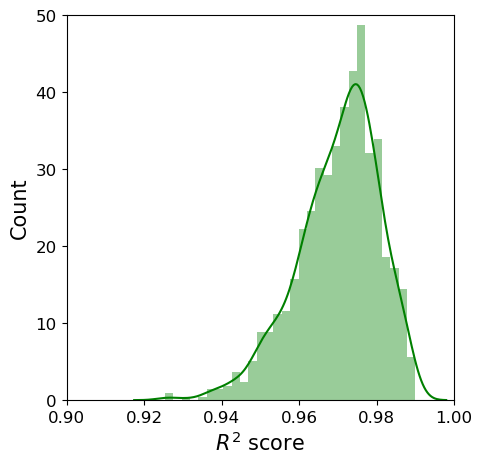

In [62]:
# 投分布图
plt.figure(figsize=(5,5),dpi=100)

ax1 = plt.subplot(111)
ax1 = sns.distplot(df11, hist = True, kde = True, bins = 30, color = 'green',
                   hist_kws = {'edgecolor':'None'}, kde_kws = {'linewidth':1.5})
ax1.set_xlim((0.90,1.0))
ax1.set_ylim((0,50))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax1.set_ylabel('Count', fontsize =15)
ax1.set_xlabel('$R^{2}$ score', fontsize =15)

#plt.savefig("mc_r2.svg", format='svg', dpi=600)
plt.show()